# Preliminari Definitivo

In [1]:
import librosa
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm 
import pandas as pd

In [ ]:
# === Percorsi ===
PD_PATH = Path('C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/Data/Data1/PD_AH')
HC_PATH = Path('C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/Data/Data1/HC_AH')

OUTPUT_PD = Path('C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/Data/Specto_pd')
OUTPUT_HC = Path('C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/Data/Specto_hc')

In [ ]:
OUTPUT_PD.mkdir(parents=True, exist_ok=True)
OUTPUT_HC.mkdir(parents=True, exist_ok=True)

# === Funzione di preprocessing ===
def process_audio_files(input_path, output_path):
    raw_audio = os.listdir(input_path)
    for wav in tqdm(raw_audio, desc=f"Processing {input_path.name}"):
        file_path = input_path / wav
        if not file_path.suffix == '.wav':
            continue  # Salta file non audio
        y, sr = librosa.load(file_path, sr=16000)
        y = librosa.util.normalize(y)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        np.save(output_path / (Path(wav).stem + ".npy"), mel)

# === Esegui preprocessing con barra di avanzamento ===
process_audio_files(PD_PATH, OUTPUT_PD)
process_audio_files(HC_PATH, OUTPUT_HC)

Dimensioni paziente sano: (128, 90)


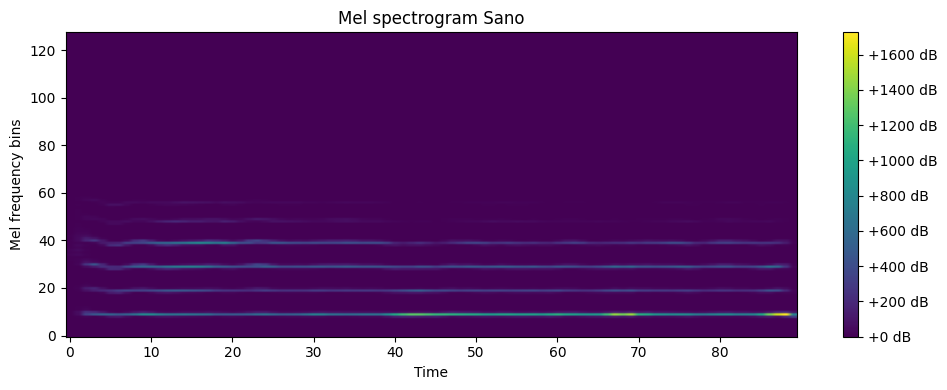

Dimensioni paziente malato: (128, 126)


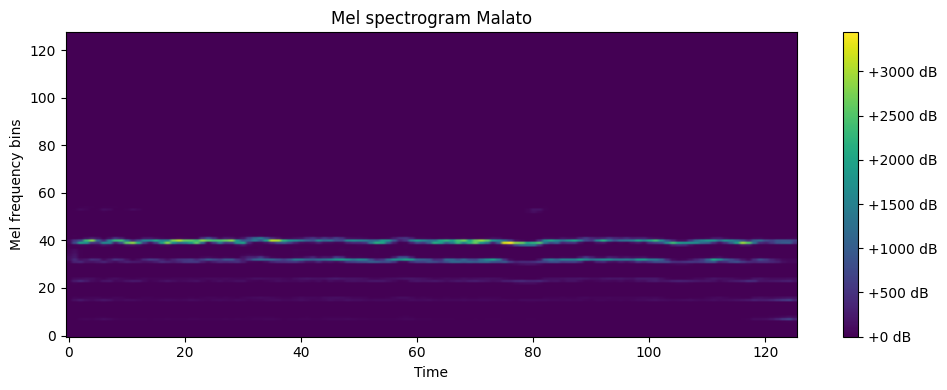

In [ ]:
# === Visualizza un esempio sano ===
pippo_sano = np.load(OUTPUT_HC / 'AH_121A_BD5BA248-E807-4CB9-8B53-47E7FFE5F8E2.npy')
print("Dimensioni paziente sano:", pippo_sano.shape)
plt.figure(figsize=(10, 4))
plt.imshow(pippo_sano, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram Sano')
plt.xlabel('Time')
plt.ylabel('Mel frequency bins')
plt.tight_layout()
plt.show()

# === Visualizza un esempio malato ===
pippo = np.load(OUTPUT_PD / 'AH_545629296-C2C009C6-8C17-42EA-B6BE-362942FC4692.npy')
print("Dimensioni paziente malato:", pippo.shape)
plt.figure(figsize=(10, 4))
plt.imshow(pippo, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram Malato')
plt.xlabel('Time')
plt.ylabel('Mel frequency bins')
plt.tight_layout()
plt.show()


import parselmouth
from parselmouth.praat import call
from pathlib import Path

# === Funzione per estrarre feature da un file audio ===
def extract_features(file_path):
    snd = parselmouth.Sound(str(file_path))

    # pitch & harmonicity
    pitch = call(snd, "To Pitch", 0.0, 75, 600)
    pointProcess = call(snd, "To PointProcess (periodic, cc)", 75, 500)
    harmonicity = call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)

    # shimmer & jitter
    local_jitter = call(pointProcess, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3)
    local_abs_jitter = call(pointProcess, "Get jitter (local, absolute)", 0.0, 0.0, 0.0001, 0.02, 1.3)
    rap_jitter = call(pointProcess, "Get jitter (rap)", 0.0, 0.0, 0.0001, 0.02, 1.3)
    ppq5_jitter = call(pointProcess, "Get jitter (ppq5)", 0.0, 0.0, 0.0001, 0.02, 1.3)
    ddp_jitter = call(pointProcess, "Get jitter (ddp)", 0.0, 0.0, 0.0001, 0.02, 1.3)

    local_shimmer = call([snd, pointProcess], "Get shimmer (local)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6)
    localdb_shimmer = call([snd, pointProcess], "Get shimmer (local_dB)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6)
    apq3_shimmer = call([snd, pointProcess], "Get shimmer (apq3)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6)
    apq5_shimmer = call([snd, pointProcess], "Get shimmer (apq5)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6)
    apq11_shimmer = call([snd, pointProcess], "Get shimmer (apq11)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6)
    dda_shimmer = call([snd, pointProcess], "Get shimmer (dda)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6)

    # harmonic-to-noise ratio
    hnr = call(harmonicity, "Get mean", 0.0, 0.0)

    # pitch stats
    meanF0 = call(pitch, "Get mean", 0, 0, "Hertz")
    stdevF0 = call(pitch, "Get standard deviation", 0, 0, "Hertz")

    return {
        "meanF0": meanF0,
        "stdevF0": stdevF0,
        "hnr": hnr,
        "localJitter": local_jitter,
        "localabsoluteJitter": local_abs_jitter,
        "rapJitter": rap_jitter,
        "ppq5Jitter": ppq5_jitter,
        "ddpJitter": ddp_jitter,
        "localShimmer": local_shimmer,
        "localdbShimmer": localdb_shimmer,
        "apq3Shimmer": apq3_shimmer,
        "apq5Shimmer": apq5_shimmer,
        "apq11Shimmer": apq11_shimmer,
        "ddaShimmer": dda_shimmer,
    }

In [ ]:
# === Analizza tutti i file PD.wav ===
folder =  PD_PATH
results = []

for wav_file in folder.glob("*.wav"):
    features = extract_features(wav_file)
    features["filename"] = wav_file.name
    results.append(features)

# === Salva in CSV per analisi o ML ===
df = pd.DataFrame(results)
df.to_csv("vsp_pd_features.csv", index=False)

# === Analizza tutti i file HC.wav ===
folder =  HC_PATH
results = []

for wav_file in folder.glob("*.wav"):
    features = extract_features(wav_file)
    features["filename"] = wav_file.name
    results.append(features)

# === Salva in CSV per analisi o ML ===
df = pd.DataFrame(results)
df.to_csv("vsp_hc_features.csv", index=False)




df_features = pd.read_csv("C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/vsp_hc_features.csv")
df_demo = pd.read_excel("C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/Demographics_age_sex.xlsx")


df_features["Sample ID"] = df_features["filename"].str.replace(".wav", "", regex=False)
df_merged = pd.merge(df_features, df_demo, on="Sample ID", how="left")
df_merged.to_csv("vsp_hc_features_with_demographics.csv", index=False)



df_features = pd.read_csv("C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/vsp_pd_features.csv")
df_demo = pd.read_excel("C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/Demographics_age_sex.xlsx")


df_features["Sample ID"] = df_features["filename"].str.replace(".wav", "", regex=False)
df_merged = pd.merge(df_features, df_demo, on="Sample ID", how="left")
df_merged.to_csv("vsp_pd_features_with_demographics.csv", index=False)

# Carica entrambi i file
df_pd = pd.read_csv("C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/vsp_pd_features_with_demographics.csv")
df_hc = pd.read_csv("C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/vsp_hc_features_with_demographics.csv")

# Unisci i due DataFrame
df_combined = pd.concat([df_pd, df_hc], ignore_index=True)

# Salva il risultato
df_combined.to_csv("vsp_all_features_with_demographics.csv", index=False)

# Regressione Logistica

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

### Data Profiling

In [4]:
def profile_dataframe(df, name='DataFrame'):
    print(f'\n=== Profiling {name} ===')
    print(f'Total Rows: {len(df)}')
    print(f'Total Columns: {len(df.columns)}\n')
    
    profile_results = []

    for col in df.columns:
        series = df[col]
        col_dtype = series.dtype
        
        # Basic counts
        total_count = len(series)
        missing_vals = series.isna().sum()
        non_null_count = total_count - missing_vals
        missing_perc = (missing_vals / total_count) * 100
        unique_vals = series.nunique(dropna=False)
        
        # Mode & frequency
        try:
            modes = series.mode(dropna=True)
            mode_val = modes.iloc[0] if len(modes) > 0 else np.nan
            mode_freq = (series == mode_val).sum(skipna=True)
        except:
            mode_val, mode_freq = np.nan, np.nan
        
        # Initialize placeholders
        mean_ = np.nan
        min_  = np.nan
        q25   = np.nan
        q50   = np.nan
        q75   = np.nan
        max_  = np.nan
        std_  = np.nan  # only for numeric columns

        # Numeric columns
        if pd.api.types.is_numeric_dtype(series):
            mean_ = series.mean(skipna=True)
            min_  = series.min(skipna=True)
            q25   = series.quantile(0.25)
            q50   = series.quantile(0.50)
            q75   = series.quantile(0.75)
            max_  = series.max(skipna=True)
            std_  = series.std(skipna=True)

        # Datetime columns
        elif pd.api.types.is_datetime64_any_dtype(series):
            # We can compute mean & quartiles by time. 
            # .quantile() and .mean() are valid for datetime in pandas
            # They return a Timestamp for mean, 
            # and Timestamps for quantiles
            if non_null_count > 0:
                mean_ = series.mean(skipna=True)
                min_  = series.min(skipna=True)
                q25   = series.quantile(0.25)
                q50   = series.quantile(0.50)
                q75   = series.quantile(0.75)
                max_  = series.max(skipna=True)
            # We skip std_ for datetime.

        # Categorical/object columns 
        # do not get numeric stats (we keep them as NaN).

        profile_results.append((
            col,
            str(col_dtype),
            total_count,
            non_null_count,
            missing_vals,
            round(missing_perc, 2),
            unique_vals,
            mode_val,
            mode_freq,
            mean_,
            min_,
            q25,
            q50,
            q75,
            max_,
            std_
        ))

    columns = [
        'Column', 'DataType', 'TotalCount', 'NonNullCount', 'NumMissing',
        'MissingPerc', 'Cardinality', 'Mode', 'ModeFreq',
        'Mean', 'Min', 'Q25', 'Q50', 'Q75', 'Max', 'Std'
    ]

    prof_df = pd.DataFrame(profile_results, columns=columns)
    
    return prof_df




In [5]:
# === Caricamento del dataset ===
df = pd.read_csv("C:/Users/cri_t/OneDrive/Desktop/Lisboa_esami/data_deep/vsp_all_features_with_demographics.csv")

df_profile = profile_dataframe(df, name='PD/HC Data')
display(HTML(df_profile.to_html()))



=== Profiling PD/HC Data ===
Total Rows: 81
Total Columns: 19



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,meanF0,float64,81,81,0,0.0,81,83.321466,1,172.022764,83.321466,125.706456,178.442618,202.720299,294.668990,50.084794
1,stdevF0,float64,81,81,0,0.0,81,0.745783,1,10.318343,0.745783,2.145909,3.037477,6.871477,116.312348,19.741220
2,hnr,float64,81,81,0,0.0,81,8.541946,1,17.769937,8.541946,15.323075,18.382952,20.972063,23.147986,3.655769
3,localJitter,float64,81,81,0,0.0,81,0.002099,1,0.006225,0.002099,0.003843,0.005155,0.007650,0.020186,0.003539
4,localabsoluteJitter,float64,81,81,0,0.0,81,0.00001,1,0.000041,0.000010,0.000021,0.000031,0.000053,0.000167,0.000031
5,rapJitter,float64,81,81,0,0.0,81,0.000899,1,0.003277,0.000899,0.001959,0.002691,0.004247,0.011046,0.001970
6,ppq5Jitter,float64,81,81,0,0.0,81,0.0011,1,0.003556,0.001100,0.002263,0.002830,0.004642,0.012587,0.002056
7,ddpJitter,float64,81,81,0,0.0,81,0.002698,1,0.009832,0.002698,0.005878,0.008074,0.012740,0.033139,0.005911
8,localShimmer,float64,81,81,0,0.0,81,0.032299,1,0.068768,0.032299,0.046068,0.059839,0.090319,0.189548,0.030981
9,localdbShimmer,float64,81,81,0,0.0,81,0.286175,1,0.619521,0.286175,0.409546,0.568726,0.778340,1.581712,0.272807


### Data Cleaning + PCA

#### Data Cleaning

In [6]:
# === Preprocessing base ===
df["label"] = (df["Label"] == "PwPD").astype(int)
df["sex"] = df["Sex"].map({"M": 0, "F": 1})
df.rename(columns={"Age": "age"}, inplace=True)
df = df.drop(columns=["Label", "Sex", "filename", "Sample ID"], errors="ignore")
df = df.dropna()

In [7]:
df_profile = profile_dataframe(df, name='PD/HC Data')
display(HTML(df_profile.to_html()))


=== Profiling PD/HC Data ===
Total Rows: 81
Total Columns: 17



,Column,DataType,TotalCount,NonNullCount,NumMissing,MissingPerc,Cardinality,Mode,ModeFreq,Mean,Min,Q25,Q50,Q75,Max,Std
0,meanF0,float64,81,81,0,0.0,81,83.321466,1,172.022764,83.321466,125.706456,178.442618,202.720299,294.668990,50.084794
1,stdevF0,float64,81,81,0,0.0,81,0.745783,1,10.318343,0.745783,2.145909,3.037477,6.871477,116.312348,19.741220
2,hnr,float64,81,81,0,0.0,81,8.541946,1,17.769937,8.541946,15.323075,18.382952,20.972063,23.147986,3.655769
3,localJitter,float64,81,81,0,0.0,81,0.002099,1,0.006225,0.002099,0.003843,0.005155,0.007650,0.020186,0.003539
4,localabsoluteJitter,float64,81,81,0,0.0,81,0.000010,1,0.000041,0.000010,0.000021,0.000031,0.000053,0.000167,0.000031
5,rapJitter,float64,81,81,0,0.0,81,0.000899,1,0.003277,0.000899,0.001959,0.002691,0.004247,0.011046,0.001970
6,ppq5Jitter,float64,81,81,0,0.0,81,0.001100,1,0.003556,0.001100,0.002263,0.002830,0.004642,0.012587,0.002056
7,ddpJitter,float64,81,81,0,0.0,81,0.002698,1,0.009832,0.002698,0.005878,0.008074,0.012740,0.033139,0.005911
8,localShimmer,float64,81,81,0,0.0,81,0.032299,1,0.068768,0.032299,0.046068,0.059839,0.090319,0.189548,0.030981
9,localdbShimmer,float64,81,81,0,0.0,81,0.286175,1,0.619521,0.286175,0.409546,0.568726,0.778340,1.581712,0.272807


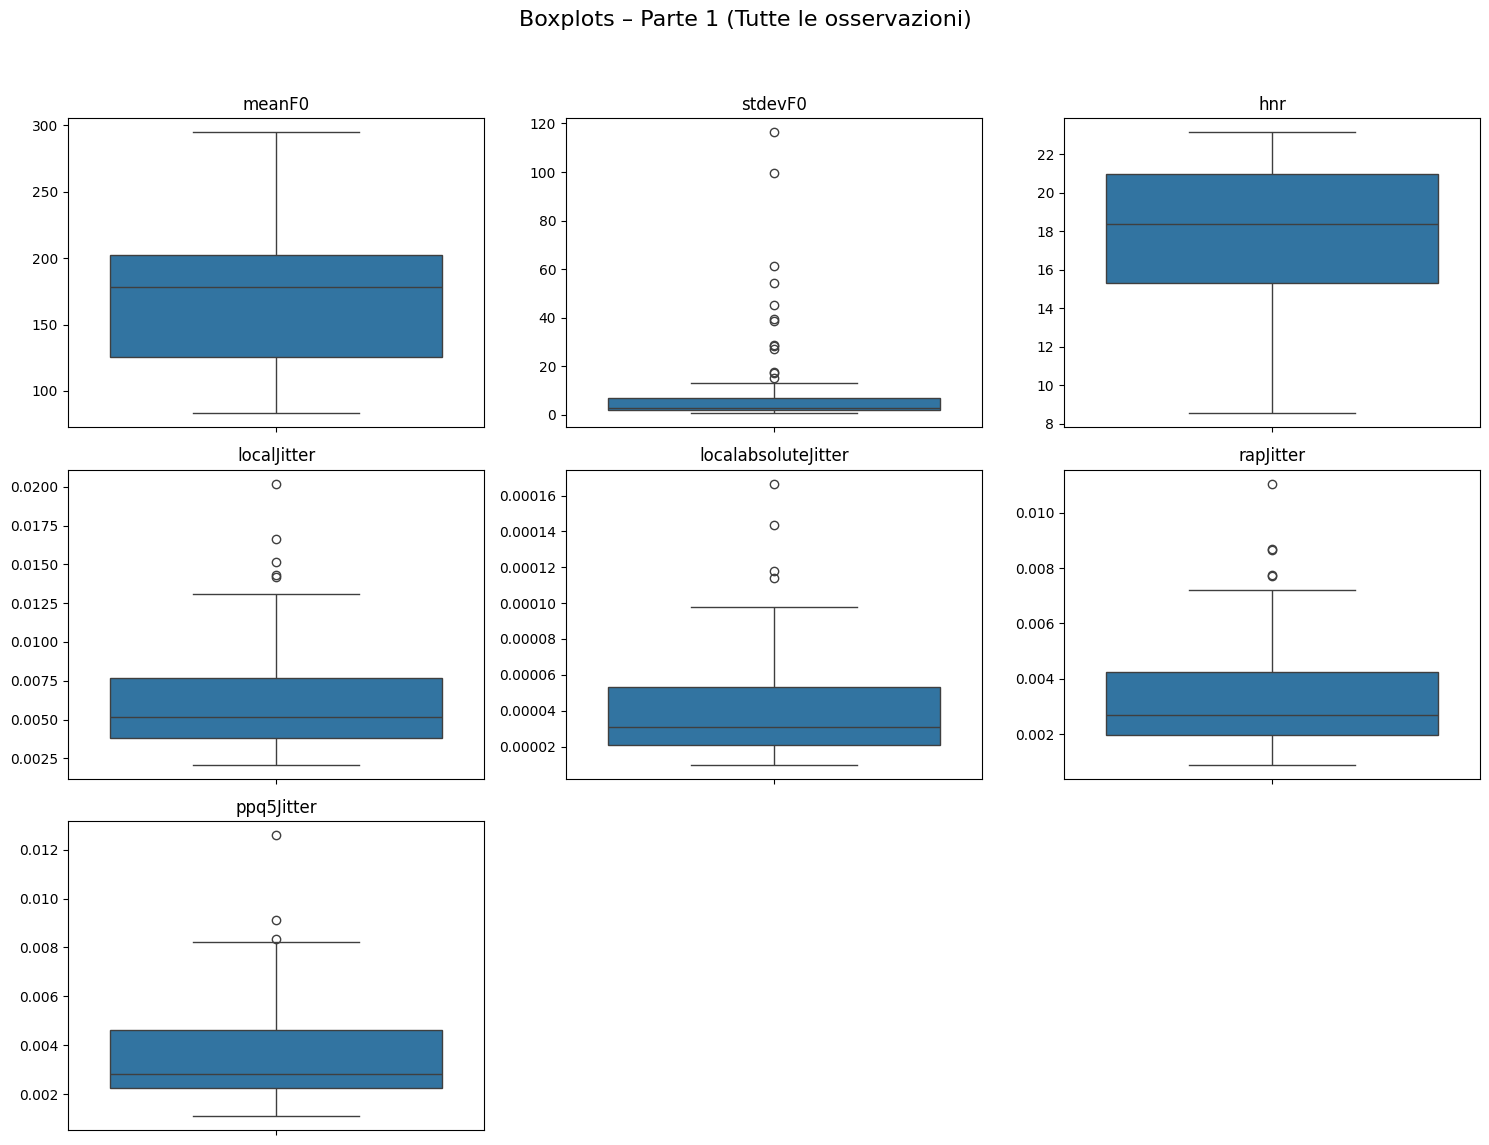

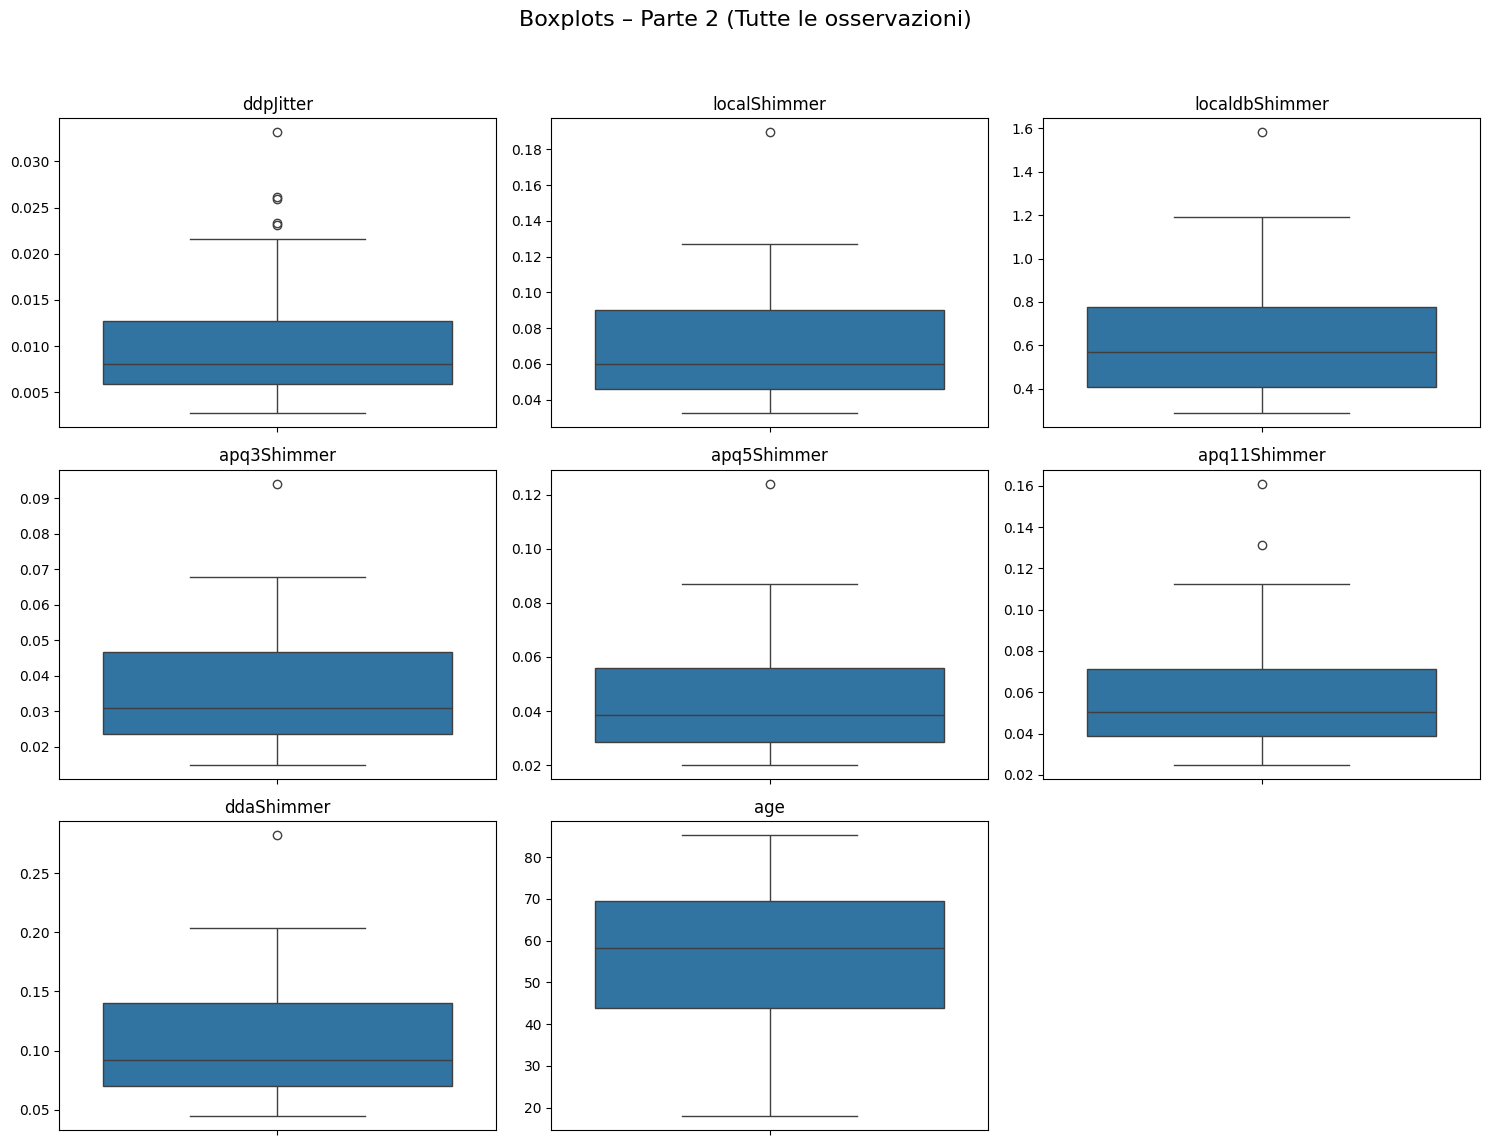

In [8]:
# === Lista delle feature numeriche (escludendo label) ===
numeric_cols = [col for col in df.columns if col != "label" and col != "sex" and df[col].dtype in ['float64', 'int64']]

# === Boxplot per ogni variabile ===
# === Suddividi in due gruppi per due figure ===
mid = len(numeric_cols) // 2
groups = [numeric_cols[:mid], numeric_cols[mid:]]

# === Funzione per creare i boxplot in subplot ===
def plot_boxplots(columns, title):
    n = len(columns)
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    # Nascondi assi inutilizzati
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# === Plot dei due gruppi di boxplot ===
plot_boxplots(groups[0], "Boxplots – Parte 1 (Tutte le osservazioni)")
plot_boxplots(groups[1], "Boxplots – Parte 2 (Tutte le osservazioni)")

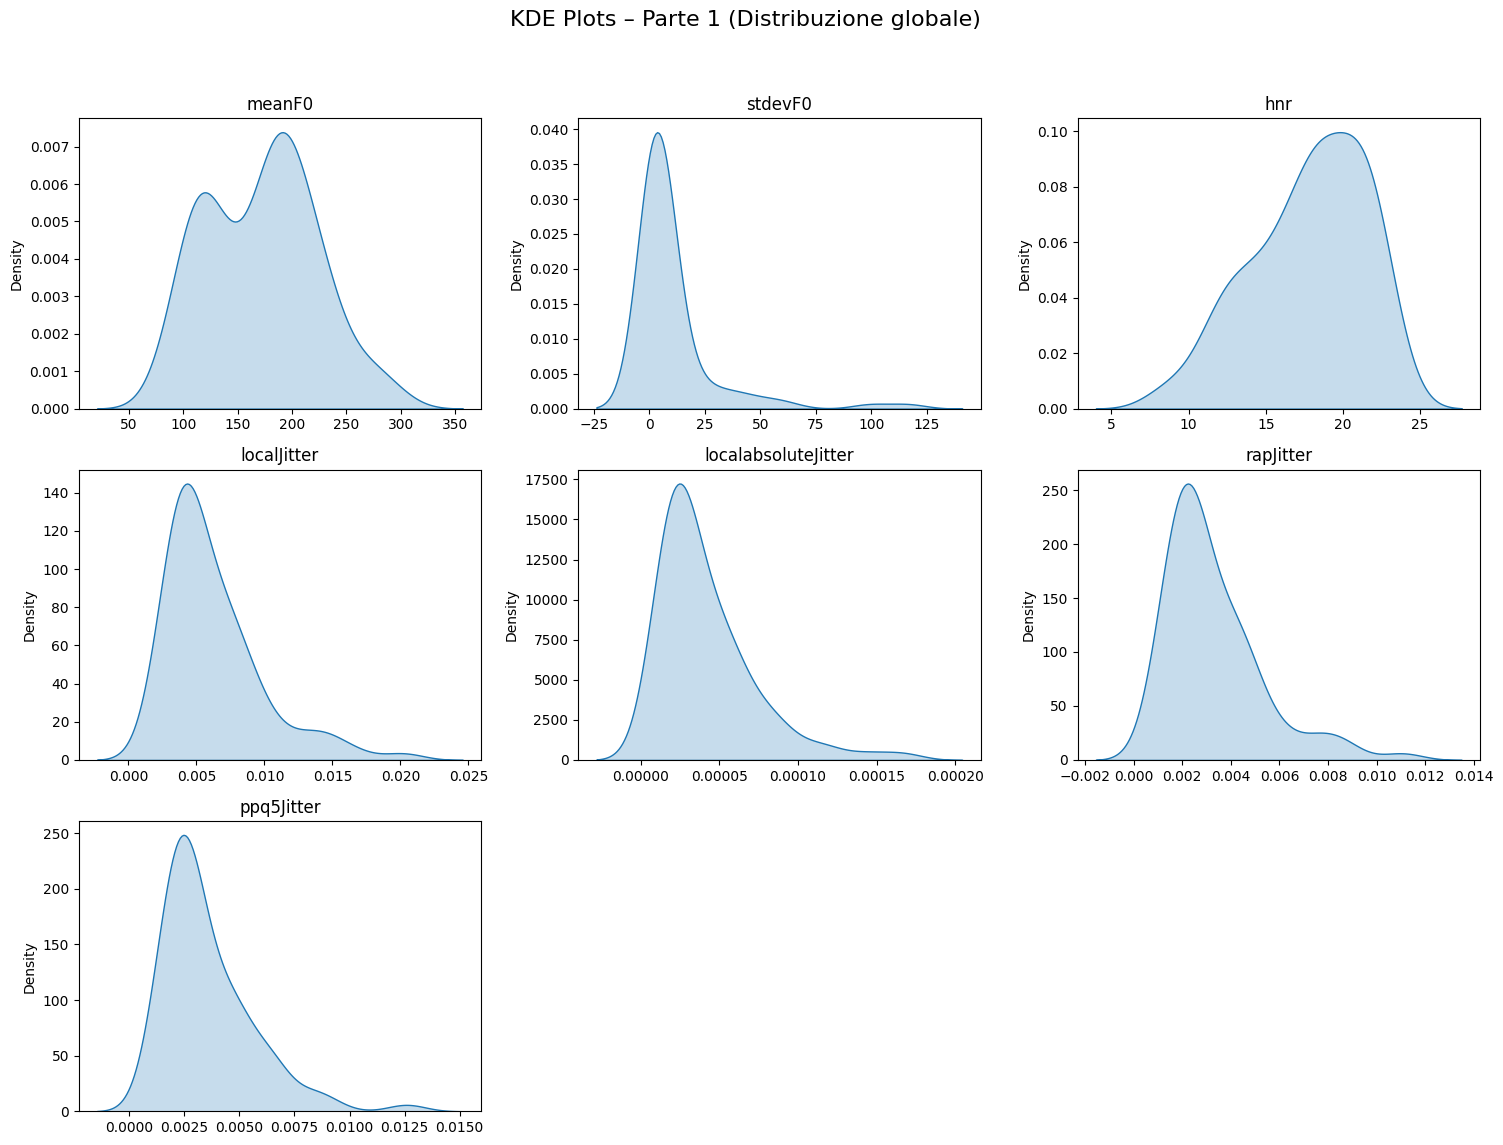

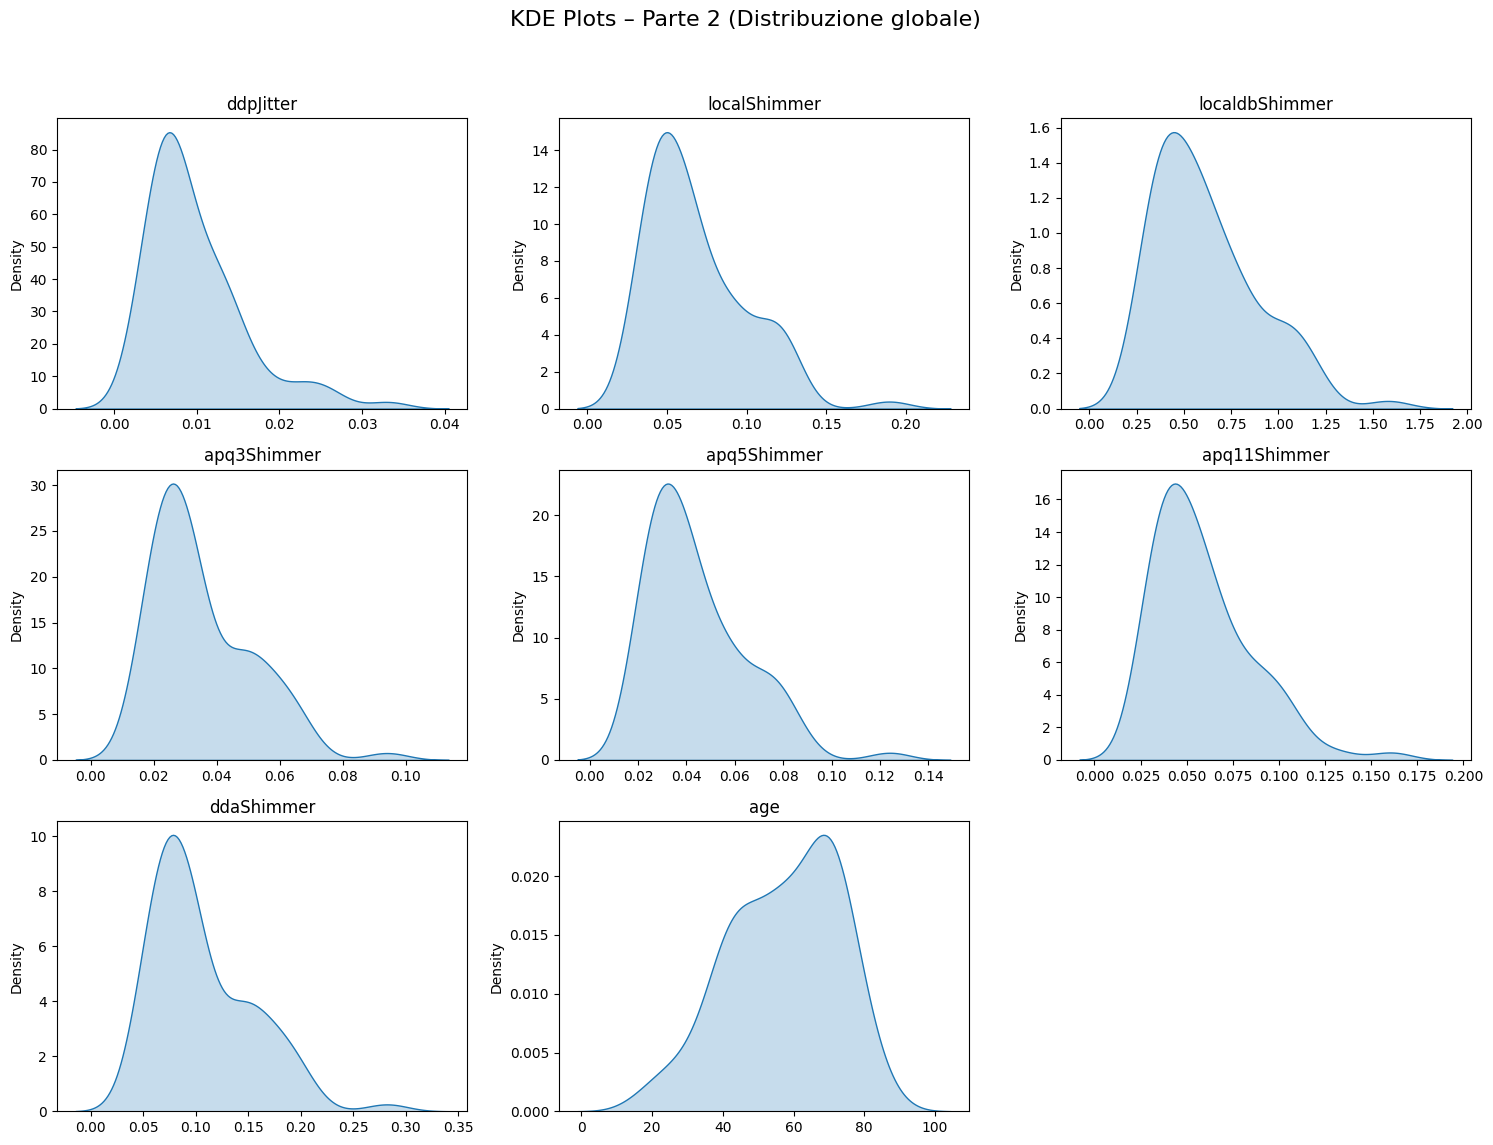

In [9]:
# === Funzione per creare KDE plot in subplot ===
def plot_kde(columns, title):
    n = len(columns)
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.kdeplot(data=df, x=col, ax=axes[i], fill=True)
        axes[i].set_title(col)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Density")

    # Nascondi assi inutilizzati
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# === Plot KDE per i due gruppi ===
plot_kde(groups[0], "KDE Plots – Parte 1 (Distribuzione globale)")
plot_kde(groups[1], "KDE Plots – Parte 2 (Distribuzione globale)")

C:\Users\cri_t\AppData\Local\Temp\ipykernel_23640\3975174237.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sex", palette="Set2", ax=axes[0])
C:\Users\cri_t\AppData\Local\Temp\ipykernel_23640\3975174237.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="Set3", ax=axes[1])


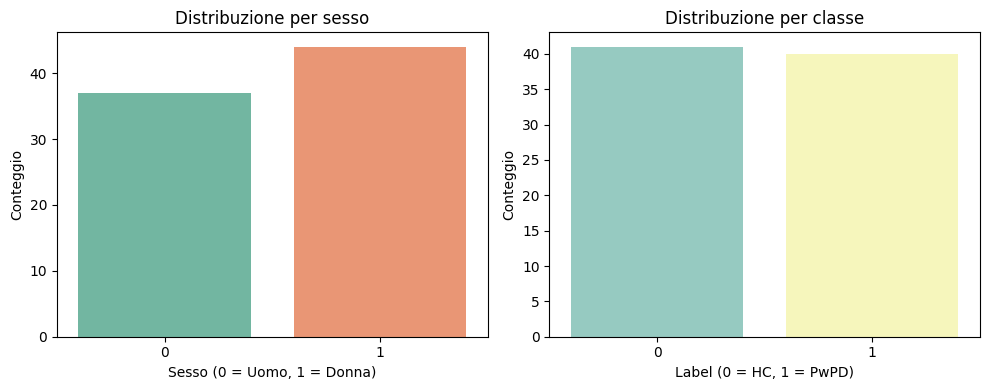

In [10]:
# === Crea la figura con due subplot affiancati ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot per sex
sns.countplot(data=df, x="sex", palette="Set2", ax=axes[0])
axes[0].set_title("Distribuzione per sesso")
axes[0].set_xlabel("Sesso (0 = Uomo, 1 = Donna)")
axes[0].set_ylabel("Conteggio")

# Plot per label
sns.countplot(data=df, x="label", palette="Set3", ax=axes[1])
axes[1].set_title("Distribuzione per classe")
axes[1].set_xlabel("Label (0 = HC, 1 = PwPD)")
axes[1].set_ylabel("Conteggio")

plt.tight_layout()
plt.show()

In [11]:
# === Applica metodo IQR per ciascuna colonna numerica (escludi 'label') ===
numeric_cols = [col for col in df.columns if col != "label" and  col != "sex" and df[col].dtype in ['float64', 'int64']]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clipping dei valori estremi
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# === Output opzionale: salva o visualizza
print("Outlier ridotti con metodo IQR.")

Outlier ridotti con metodo IQR.


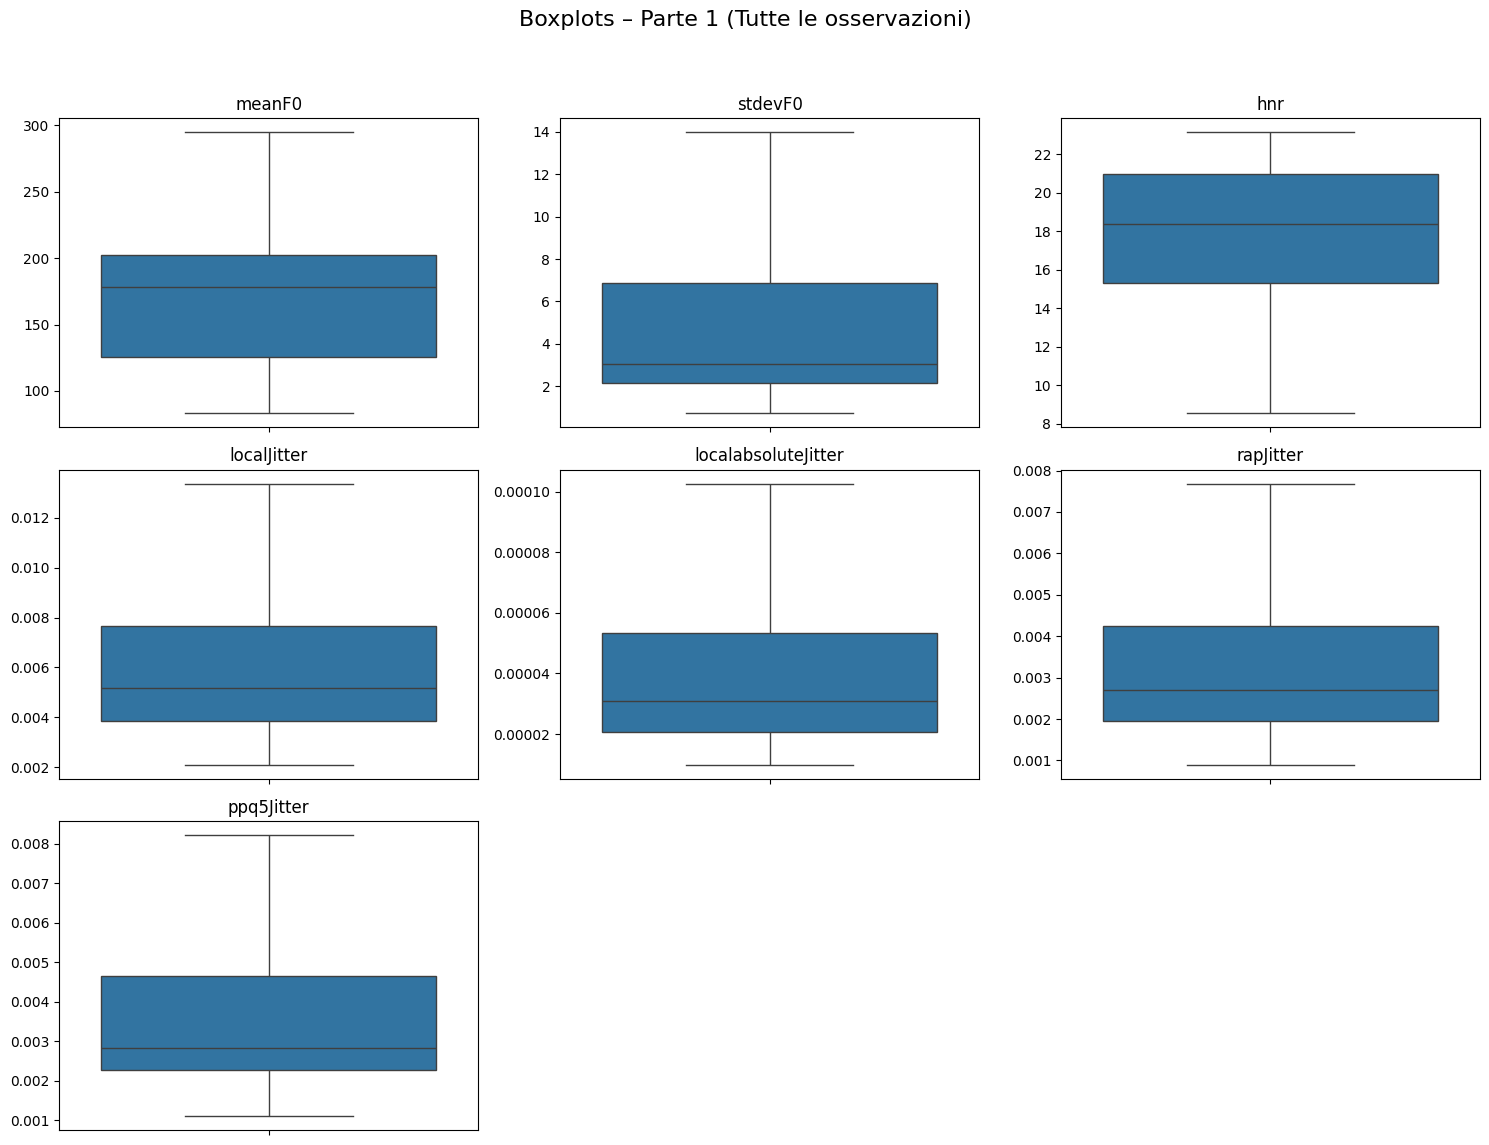

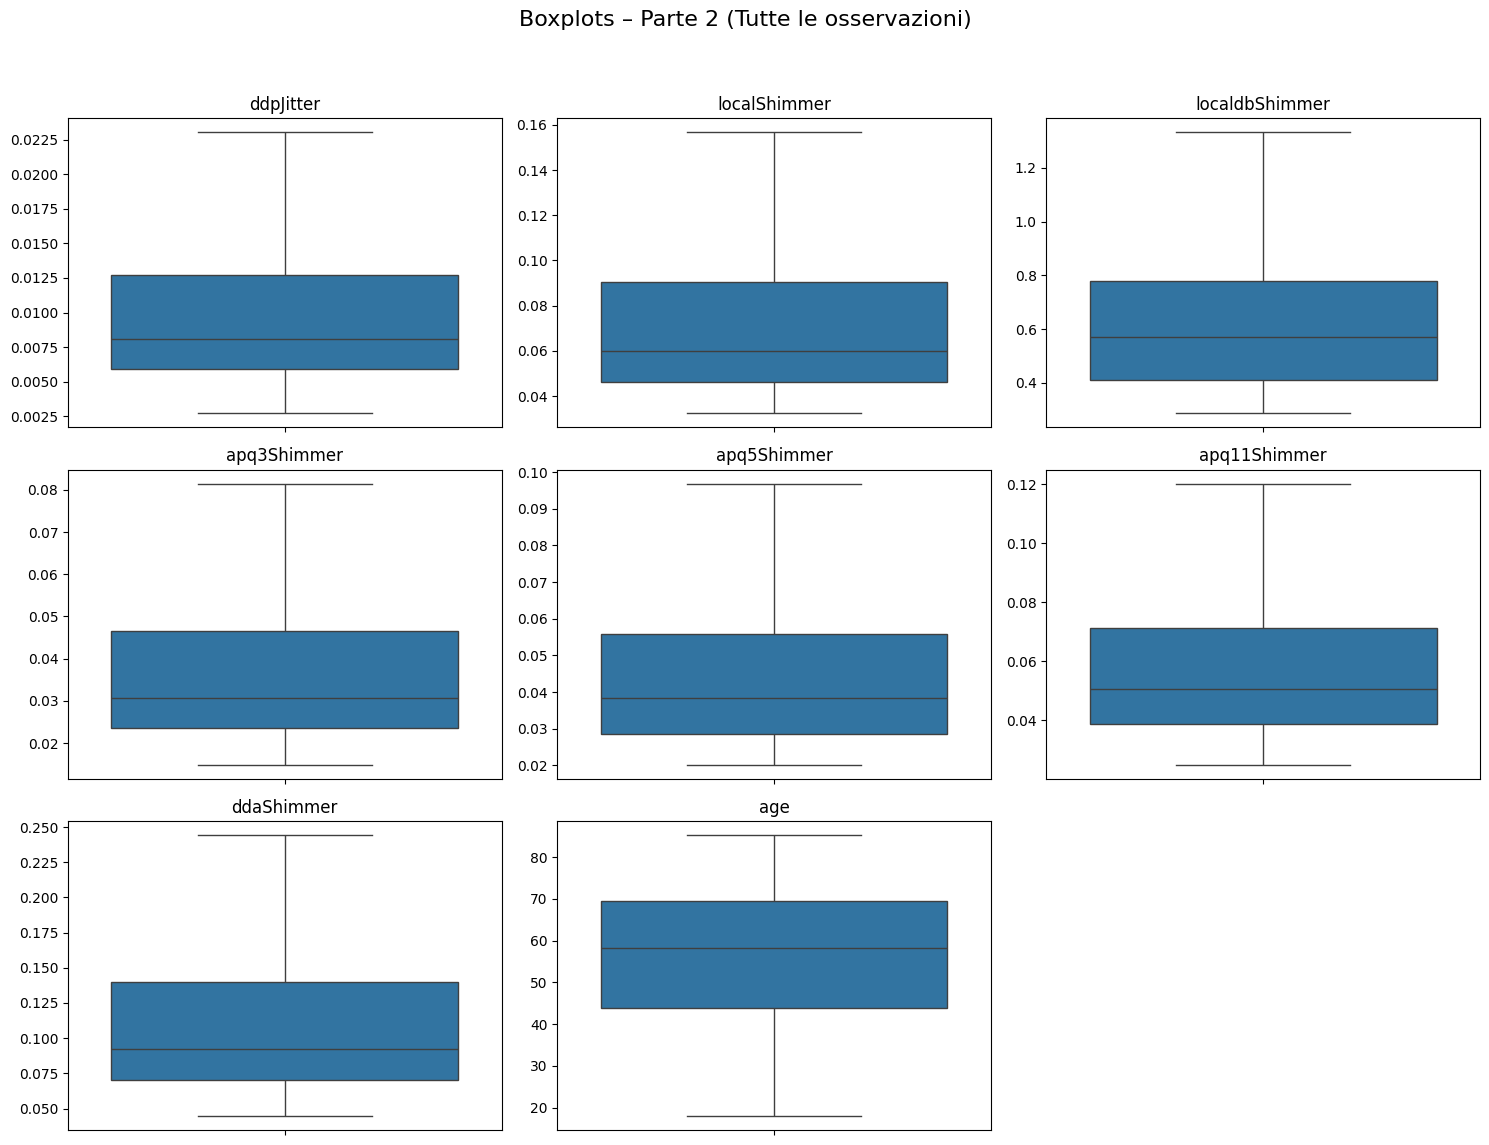

In [12]:
# === Boxplot per ogni variabile ===
# === Suddividi in due gruppi per due figure ===
mid = len(numeric_cols) // 2
groups = [numeric_cols[:mid], numeric_cols[mid:]]

# === Plot dei due gruppi di boxplot ===
plot_boxplots(groups[0], "Boxplots – Parte 1 (Tutte le osservazioni)")
plot_boxplots(groups[1], "Boxplots – Parte 2 (Tutte le osservazioni)")





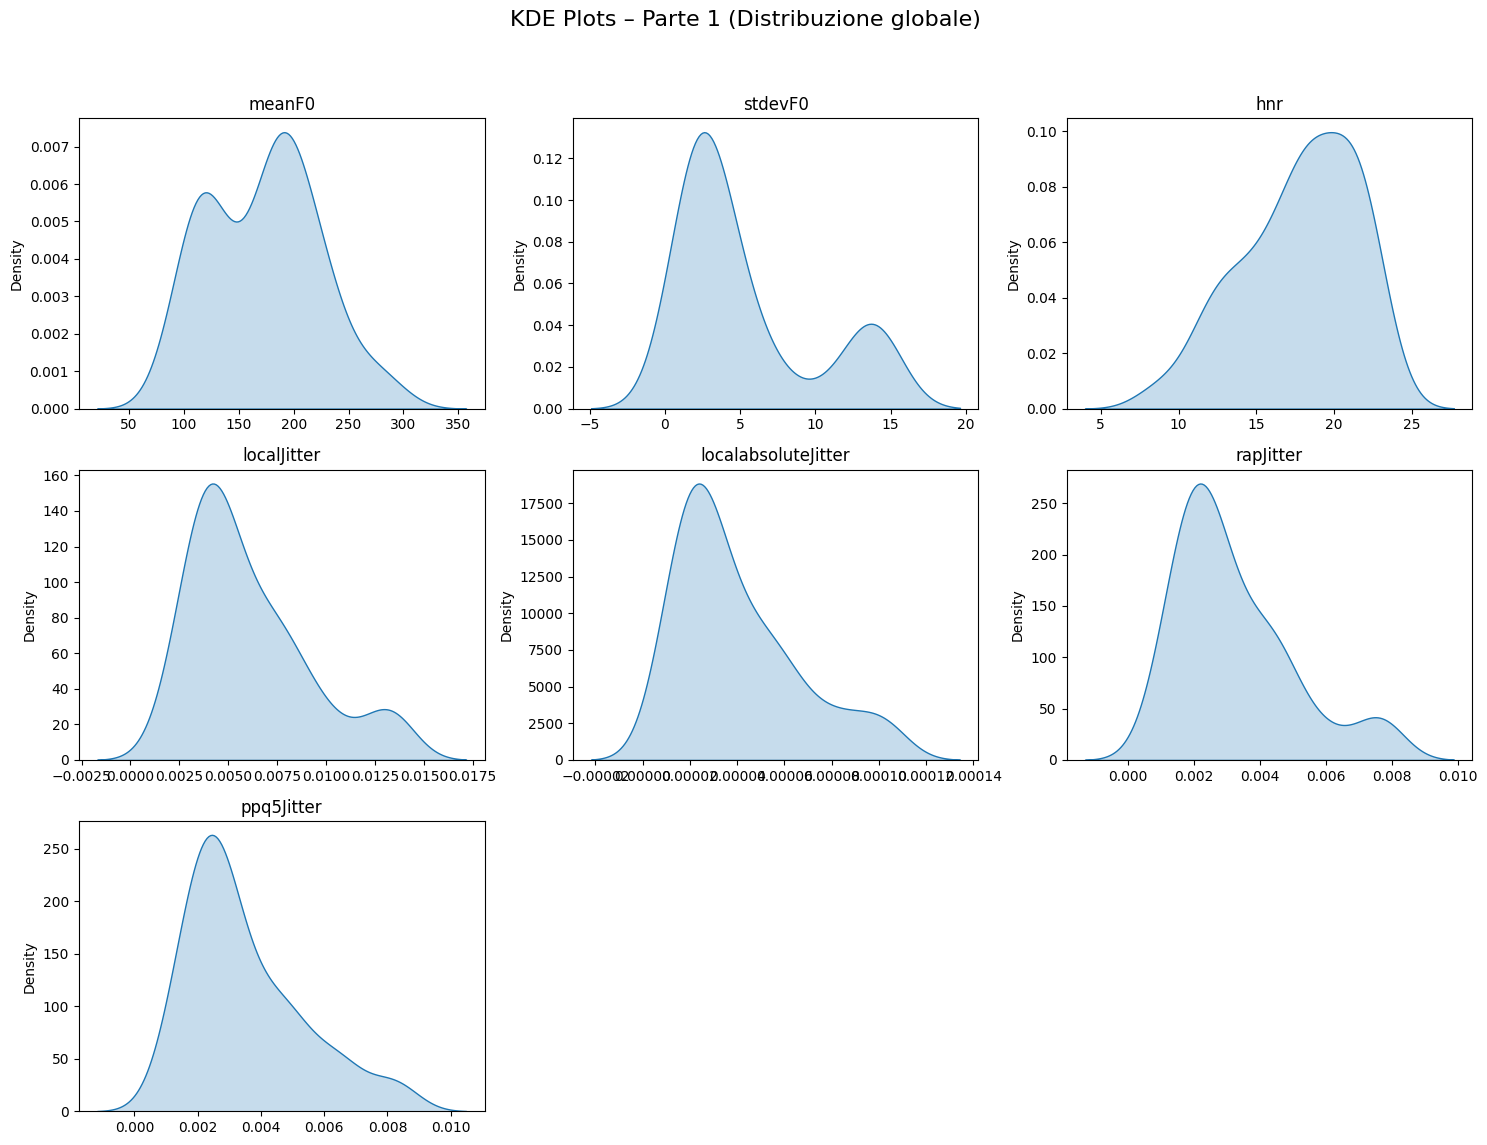

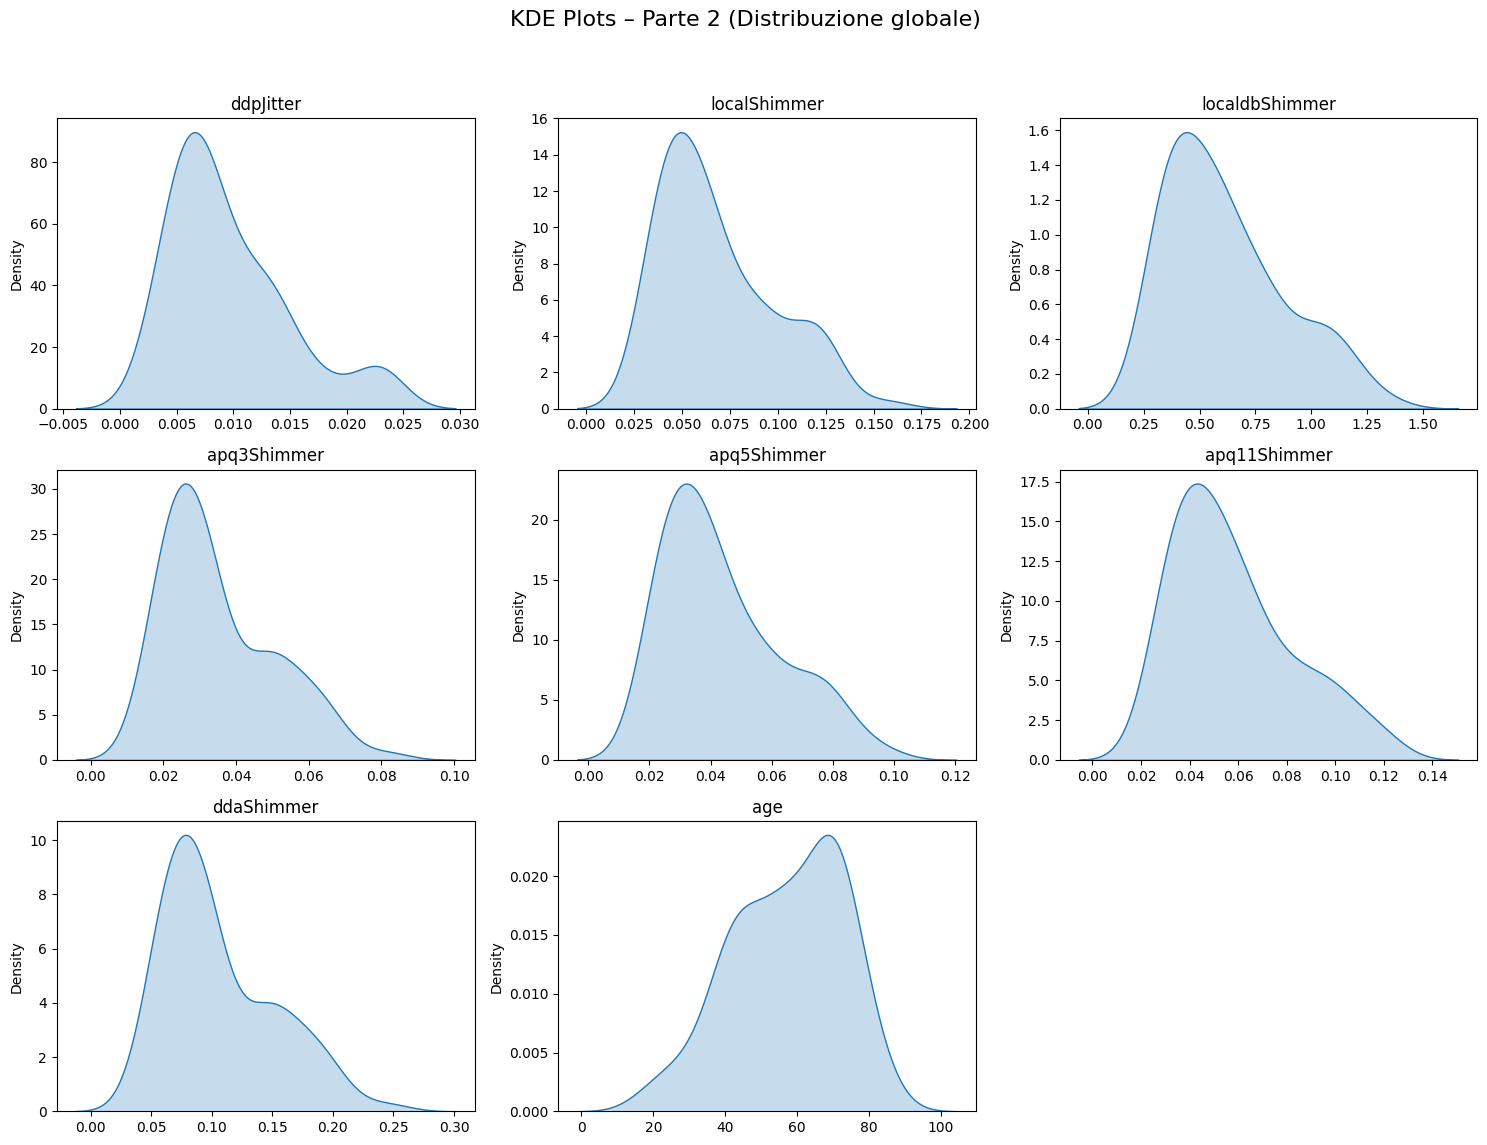

In [13]:
# === Plot KDE per i due gruppi ===
plot_kde(groups[0], "KDE Plots – Parte 1 (Distribuzione globale)")
plot_kde(groups[1], "KDE Plots – Parte 2 (Distribuzione globale)")

#### PCA

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
import statsmodels.api as sm

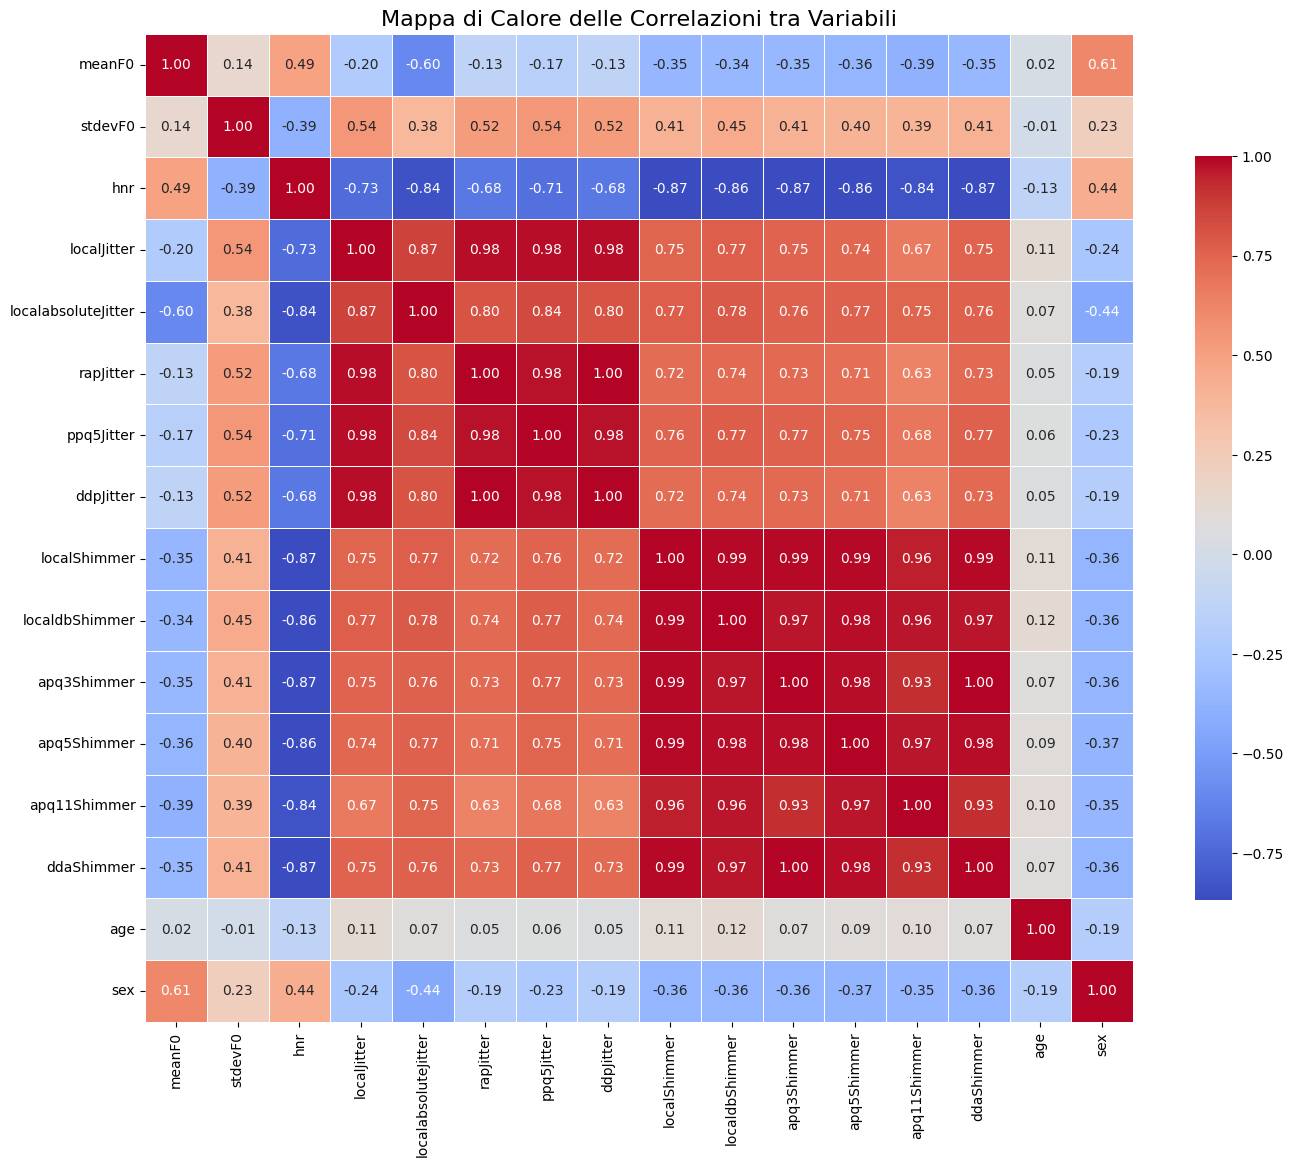

In [15]:
# === Rimuove target (label) per concentrarsi solo sulle feature
df_corr = df.drop(columns=["label"], errors="ignore")

# === Calcolo matrice di correlazione
corr_matrix = df_corr.corr()

# === Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, cbar_kws={"shrink": 0.7})
plt.title("Mappa di Calore delle Correlazioni tra Variabili", fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
# === Separa feature e target
X = df.drop(columns=["label"])
y = df["label"]

In [17]:
# === Aggiunta costante (necessaria per VIF)
X_const = add_constant(X)

# === Calcolo VIF per ogni variabile (escludi costante)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

c:\Users\cri_t\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [18]:
# Rimuove la riga della costante per analisi
vif_data = vif_data[vif_data["Feature"] != "const"]

# === Visualizza risultati
print("\nVariance Inflation Factor (VIF) per ciascuna variabile:\n")
print(vif_data.sort_values(by="VIF", ascending=False))


Variance Inflation Factor (VIF) per ciascuna variabile:

                Feature         VIF
8             ddpJitter         inf
6             rapJitter         inf
14           ddaShimmer         inf
11          apq3Shimmer         inf
9          localShimmer  120.106720
12          apq5Shimmer  112.065141
4           localJitter   79.644031
10       localdbShimmer   65.202802
7            ppq5Jitter   41.578744
13         apq11Shimmer   37.974147
5   localabsoluteJitter   25.834151
3                   hnr    7.180926
1                meanF0    5.730179
16                  sex    2.204419
2               stdevF0    2.161662
15                  age    1.287032


In [19]:
# === Lista delle variabili da trasformare con PCA
jitter_cols = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter']
shimmer_cols = ['localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']

# === Standardizzazione delle variabili prima della PCA
scaler = StandardScaler()
jitter_scaled = scaler.fit_transform(df[jitter_cols])
shimmer_scaled = scaler.fit_transform(df[shimmer_cols])

# === PCA (1 componente per ciascun gruppo)
pca_jitter = PCA(n_components=1)
pca_shimmer = PCA(n_components=1)

df["JitterPCA"] = pca_jitter.fit_transform(jitter_scaled)
df["ShimmerPCA"] = pca_shimmer.fit_transform(shimmer_scaled)


# === Rimozione delle colonne originali (opzionale)
df2 = df.drop(columns=jitter_cols + shimmer_cols)



In [20]:
corr = df["JitterPCA"].corr(df["ShimmerPCA"])
print(f"Correlazione Pearson: {corr:.3f}")

# Rimuove la colonna target
X = df2.drop(columns=["label"])

# Aggiunge una costante (intercetta)
X_const = add_constant(X)

# Calcolo VIF per ciascuna variabile
vif_df = pd.DataFrame()
vif_df["Feature"] = X_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Rimuove la costante dalla visualizzazione
vif_df = vif_df[vif_df["Feature"] != "const"]

# Visualizza
print("\n=== VIF (Variance Inflation Factor) ===\n")
print(vif_df)

Correlazione Pearson: 0.767

=== VIF (Variance Inflation Factor) ===

      Feature       VIF
1      meanF0  1.975251
2     stdevF0  1.823654
3         hnr  5.582232
4         age  1.087821
5         sex  1.992301
6   JitterPCA  2.973685
7  ShimmerPCA  4.800649


In [21]:
df2.head()


,meanF0,stdevF0,hnr,age,label,sex,JitterPCA,ShimmerPCA
0,126.353888,3.375199,13.645093,64.46,1,0,0.577129,-0.222712
1,110.262920,8.659191,15.480307,76.73,1,0,-0.252691,2.172886
2,236.978227,5.610969,18.682661,72.23,1,1,-1.778593,-0.389668
3,263.086609,13.959828,17.203112,69.45,1,1,2.845085,-0.783996
4,161.322442,2.327310,20.720847,67.59,1,0,-1.626248,-1.075210


In [22]:
df2.shape

(81, 8)

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   meanF0      81 non-null     float64
 1   stdevF0     81 non-null     float64
 2   hnr         81 non-null     float64
 3   age         81 non-null     float64
 4   label       81 non-null     int64  
 5   sex         81 non-null     int64  
 6   JitterPCA   81 non-null     float64
 7   ShimmerPCA  81 non-null     float64
dtypes: float64(6), int64(2)
memory usage: 5.2 KB


### Regressione Logistica + Risultati con Cross Validation K-fold

In [24]:
X = df2.drop(columns=["label"])
y = df2["label"]

# === Standardizza tutte le feature (incluse PCA) ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df = sm.add_constant(X_scaled_df)  # Aggiunge l'intercetta

# === K-FOLD CROSS VALIDATION ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
recall_scores = []
f1_scores = []

print("\n=== K-FOLD CROSS VALIDATION (5 folds) ===\n")

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled_df, y), 1):
    X_train, X_test = X_scaled_df.iloc[train_idx], X_scaled_df.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = sm.Logit(y_train, X_train)
    result = model.fit(disp=0)  # silenzioso

    y_pred_prob = result.predict(X_test)
    y_pred = (y_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_scores.append(acc)
    recall_scores.append(rec)
    f1_scores.append(f1)

    print(f"Fold {fold}: Accuracy={acc:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

# === Metriche medie ===
print("\n=== Media delle metriche ===")
print(f"Accuracy media: {np.mean(accuracy_scores):.3f}")
print(f"Recall media:   {np.mean(recall_scores):.3f}")
print(f"F1-score media: {np.mean(f1_scores):.3f}")

# === Stima finale di Odds Ratios e P-values su tutto il dataset ===
model_final = sm.Logit(y, X_scaled_df)
result_final = model_final.fit()

odds_ratios = np.exp(result_final.params)
p_values = result_final.pvalues

summary_df = pd.DataFrame({
    "Coefficient": result_final.params,
    "Odds Ratio": odds_ratios,
    "p-value": p_values
}).sort_values(by="p-value")

print("\n=== Odds Ratios e P-values (intero dataset) ===\n")
print(summary_df)


=== K-FOLD CROSS VALIDATION (5 folds) ===

Fold 1: Accuracy=0.647, Recall=0.875, F1=0.700
Fold 2: Accuracy=0.750, Recall=0.875, F1=0.778
Fold 3: Accuracy=0.875, Recall=0.750, F1=0.857
Fold 4: Accuracy=0.750, Recall=0.625, F1=0.714
Fold 5: Accuracy=0.750, Recall=0.750, F1=0.750

=== Media delle metriche ===
Accuracy media: 0.754
Recall media:   0.775
F1-score media: 0.760
Optimization terminated successfully.
         Current function value: 0.325521
         Iterations 7

=== Odds Ratios e P-values (intero dataset) ===

            Coefficient  Odds Ratio   p-value
age            2.184958    8.890273  0.000039
meanF0         2.248483    9.473353  0.002762
sex           -1.626073    0.196701  0.008611
stdevF0        0.633373    1.883954  0.182360
ShimmerPCA    -0.890572    0.410421  0.307985
hnr           -0.722900    0.485343  0.412439
JitterPCA     -0.181176    0.834288  0.798159
const         -0.037534    0.963162  0.918808
